In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from utils import *
import scipy.stats
import seaborn as sns
from ipywidgets import interact, interactive, FloatProgress, IntProgress

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
fx_1minute_bar_catalog()

defaultdict(list,
            {'EURGBP': ['2015', '2014', '2013', '2016', '2012'],
             'EURJPY': ['2012', '2015', '2013', '2016', '2014'],
             'EURUSD': ['2012', '201612', '2013', '2014', '2016', '2015'],
             'GBPCHF': ['2015', '2014', '2016'],
             'GBPJPY': ['2016', '2013', '2015', '2014', '2012'],
             'GBPUSD': ['2013', '2015', '2012', '2014', '2016'],
             'USDJPY': ['2013', '2016', '2014', '2015', '2012'],
             'XAGUSD': ['2013', '2015', '2016', '2012', '2014'],
             'XAUGBP': ['2012', '2016', '2015', '2014', '2013'],
             'XAUUSD': ['2012', '2015', '2014', '2013', '2016']})

In [3]:
ds = load_1minute_fx_bars('EURJPY', 2014)
del ds['volume']
ds.head()

,open,high,low,close
ts,,,,
2014-01-01 17:01:00,144.816,144.861,144.811,144.815
2014-01-01 17:02:00,144.837,144.853,144.807,144.853
2014-01-01 17:03:00,144.854,144.882,144.854,144.882
2014-01-01 17:04:00,144.893,144.893,144.892,144.893
2014-01-01 17:05:00,144.893,144.945,144.882,144.917


In [4]:
def compute_signal(ds, lookahead=15, target_bps=25, max_dip_bps=10):
    BPS = 1.0e-4
    fut_close = ds['close'].shift(-lookahead)
    fut_ret = fut_close/ds['close'] -1

    # to avoid sign confusion. drive this always just form the sign of the target bps
    max_dip_bps = abs(max_dip_bps)
    
    up = target_bps > 0
    
    if up:
        sig1 = fut_ret > target_bps*BPS
        cut_off = ds['close'] * (1-max_dip_bps * BPS)
        limit_in_lookahead = ds['low'].shift(-lookahead).rolling(lookahead).min()
        sig = sig1 & (limit_in_lookahead > cut_off)
    else:
        sig1 = fut_ret < target_bps*BPS
        cut_off = ds['close'] * (1+max_dip_bps * BPS)
        limit_in_lookahead = ds['high'].shift(-lookahead).rolling(lookahead).max()
        sig = sig1 & (limit_in_lookahead < cut_off)
    
#     ds['sig1'] = sig1
#     ds['cut_off'] = cut_off
#     ds['limit_in_la'] = limit_in_lookahead
#     ds['sig'] = sig
#     ds['sig'].sum()
    
    return sig

In [5]:
ds = ds.resample('1min').mean()


338
339
0.0151657706093


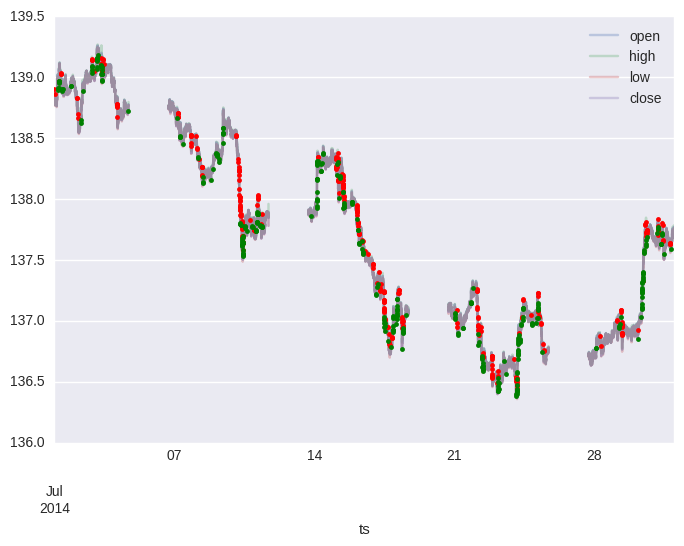

In [14]:
sell_sig = compute_signal(ds, lookahead=5, target_bps=-4, max_dip_bps=2)
buy_sig = compute_signal(ds, lookahead=5, target_bps=4, max_dip_bps=2)
date = '2014-07'
ds[date].plot(alpha=0.3)
sells = ds['close'][sell_sig][date]
buys = ds['close'][buy_sig][date]
if len(sells) > 0:
    sells.plot(style='.', color='red')
if len(buys) > 0:
    buys.plot(style='.', color='green')
print buy_sig[date].sum()
print sell_sig[date].sum()
print (buy_sig[date].sum() + sell_sig[date].sum() )/len(buy_sig[date])

In [16]:
buy_sig.tail()

ts
2014-12-31 16:54:00    False
2014-12-31 16:55:00    False
2014-12-31 16:56:00    False
2014-12-31 16:57:00    False
2014-12-31 16:58:00    False
Freq: T, dtype: bool

2.9500000000000002

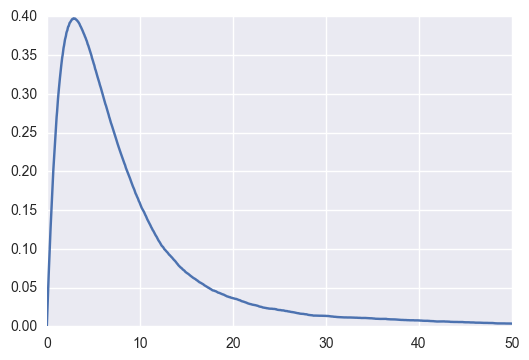

In [21]:
# frequency of occurrence versus value of move
lookahead=15
BPS = 1e-4
fut_close = ds['close'].shift(-lookahead)
fut_ret = fut_close/ds['close'] -1
ts = []
vals = []
for t in np.linspace(0,50,1001):
    freq = ((fut_ret >  t*BPS)*1).mean()
    value = freq * t
    ts.append(t)
    vals.append(value)
plt.plot(ts, vals)
ts[np.argmax(vals)]

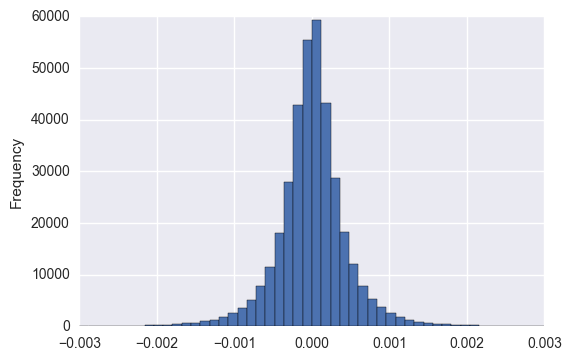

In [28]:
fut_ret.plot.hist(bins=50, range=(-0.003,0.003))

In [30]:
groups = fut_ret.groupby(pd.TimeGrouper('M'))

1 <class 'pandas.core.series.Series'>
2 <class 'pandas.core.series.Series'>
3 <class 'pandas.core.series.Series'>
4 <class 'pandas.core.series.Series'>
5 <class 'pandas.core.series.Series'>
6 <class 'pandas.core.series.Series'>
7 <class 'pandas.core.series.Series'>
8 <class 'pandas.core.series.Series'>
9 <class 'pandas.core.series.Series'>
10 <class 'pandas.core.series.Series'>
11 <class 'pandas.core.series.Series'>
12 <class 'pandas.core.series.Series'>


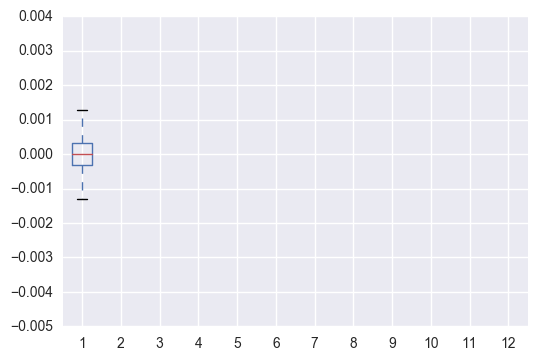

In [35]:
months = pd.DataFrame()
for name, group in groups:
    print name.month, type(group)
    months[name.month] = group
months.boxplot()

In [39]:
fut_ret.head()

ts
2014-01-01 17:01:00    0.000718
2014-01-01 17:02:00    0.000152
2014-01-01 17:03:00   -0.000145
2014-01-01 17:04:00    0.000097
2014-01-01 17:05:00    0.000090
Freq: T, Name: close, dtype: float64

In [45]:
from pandas.tools.plotting import autocorrelation_plot, lag_plot

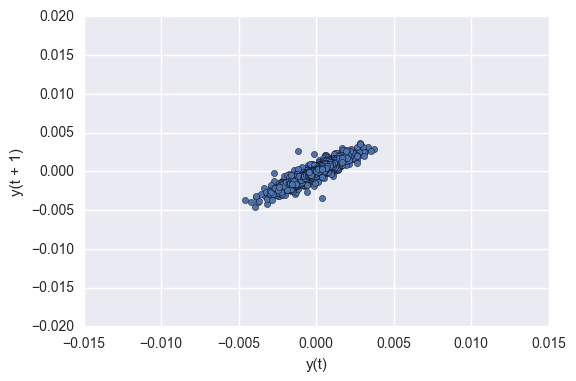

In [50]:
lag_plot(fut_ret['2014-01'])

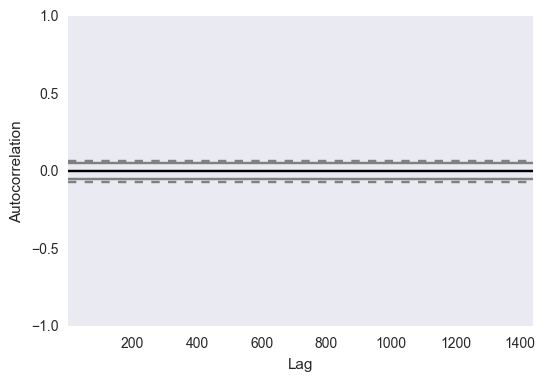

In [53]:
autocorrelation_plot(fut_ret['2014-01-04'])

In [102]:
ret = logreturn(ds['close'], ds['close'].shift(1))
ret

ts
2014-01-01 17:01:00         NaN
2014-01-01 17:02:00    0.000262
2014-01-01 17:03:00    0.000200
2014-01-01 17:04:00    0.000076
2014-01-01 17:05:00    0.000166
2014-01-01 17:06:00    0.000110
2014-01-01 17:07:00    0.000048
2014-01-01 17:08:00         NaN
2014-01-01 17:09:00         NaN
2014-01-01 17:10:00    0.000034
2014-01-01 17:11:00         NaN
2014-01-01 17:12:00         NaN
2014-01-01 17:13:00   -0.000580
2014-01-01 17:14:00   -0.000545
2014-01-01 17:15:00    0.000628
2014-01-01 17:16:00   -0.000007
2014-01-01 17:17:00   -0.000304
2014-01-01 17:18:00   -0.000097
2014-01-01 17:19:00    0.000317
2014-01-01 17:20:00    0.000159
2014-01-01 17:21:00   -0.000014
2014-01-01 17:22:00    0.000076
2014-01-01 17:23:00   -0.000014
2014-01-01 17:24:00    0.000310
2014-01-01 17:25:00    0.000041
2014-01-01 17:26:00   -0.000262
2014-01-01 17:27:00   -0.000076
2014-01-01 17:28:00   -0.000442
2014-01-01 17:29:00         NaN
2014-01-01 17:30:00         NaN
                         ...   
2014-

## Baselines: last value, zero, moving averages, ewmas

In [104]:
truth = ret.shift(-1).fillna(0)
prediction0 = np.zeros(len(ret))
prediction1 = ret.fillna(0)
prediction2 = ret.ewm(6).mean().fillna(0)
print truth.shape, prediction1.shape, prediction2.shape

from sklearn.metrics import mean_squared_error
print "predict zero", np.sqrt(mean_squared_error(truth, prediction0))/truth.std()
print "predict last value", np.sqrt(mean_squared_error(truth, prediction1))/truth.std()


for i in range(40):
    print "ewma",i,np.sqrt(mean_squared_error(truth, ret.ewm(i).mean().fillna(0)))/truth.std()
    
for i in range(20):
    print "ma",i,np.sqrt(mean_squared_error(truth, ret.rolling(i).mean().fillna(0)))/truth.std()

(524158,) (524158,) (524158,)
predict zero 0.999999047153
predict last value 1.43360312167
ewma 0 1.99919124826
ewma 1 1.35408901786
ewma 2 1.19806096429
ewma 3 1.13356820948
ewma 4 1.09970070384
ewma 5 1.079225943
ewma 6 1.06562716377
ewma 7 1.05596907214
ewma 8 1.04876100309
ewma 9 1.04317499323
ewma 10 1.03871763694
ewma 11 1.03507764913
ewma 12 1.03204917582
ewma 13 1.02949062012
ewma 14 1.02730129725
ewma 15 1.02540756675
ewma 16 1.02375425515
ewma 17 1.02229916016
ewma 18 1.02100941809
ewma 19 1.01985903573
ewma 20 1.01882717187
ewma 21 1.01789691432
ewma 22 1.01705439231
ewma 23 1.01628812101
ewma 24 1.01558850971
ewma 25 1.0149474875
ewma 26 1.01435821475
ewma 27 1.01381485814
ewma 28 1.01331241334
ewma 29 1.01284656393
ewma 30 1.01241356815
ewma 31 1.01201016728
ewma 32 1.01163351097
ewma 33 1.01128109591
ewma 34 1.01095071521
ewma 35 1.01064041637
ewma 36 1.01034846608
ewma 37 1.01007332076
ewma 38 1.00981360164
ewma 39 1.00956807365
ma 0 0.999999047153
ma 1 1.43360312167
ma 

## Baseline is 1 std. by predicting zero.